In [1]:
import torch
from transformers import ViTFeatureExtractor, ViTModel, BertTokenizer, BertModel
import torch.nn as nn
from PIL import Image
import pandas as pd

In [2]:
vit_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

class MultimodalModel(nn.Module):
    def __init__(self, vit_model, bert_model):
        super(MultimodalModel, self).__init__()
        self.vit_model = vit_model
        self.bert_model = bert_model
        self.fc = nn.Linear(vit_model.config.hidden_size + bert_model.config.hidden_size, 3) 

    def forward(self, image, text):
        img_features = self.vit_model(image).pooler_output
        
        text_inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        text_outputs = self.bert_model(**text_inputs)
        text_features = text_outputs.pooler_output
        
        combined_features = torch.cat((img_features, text_features), dim=1)
        
        logits = self.fc(combined_features)
        return logits

model = MultimodalModel(vit_model, bert_model)

/Users/wery/Library/Python/3.9/lib/python/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


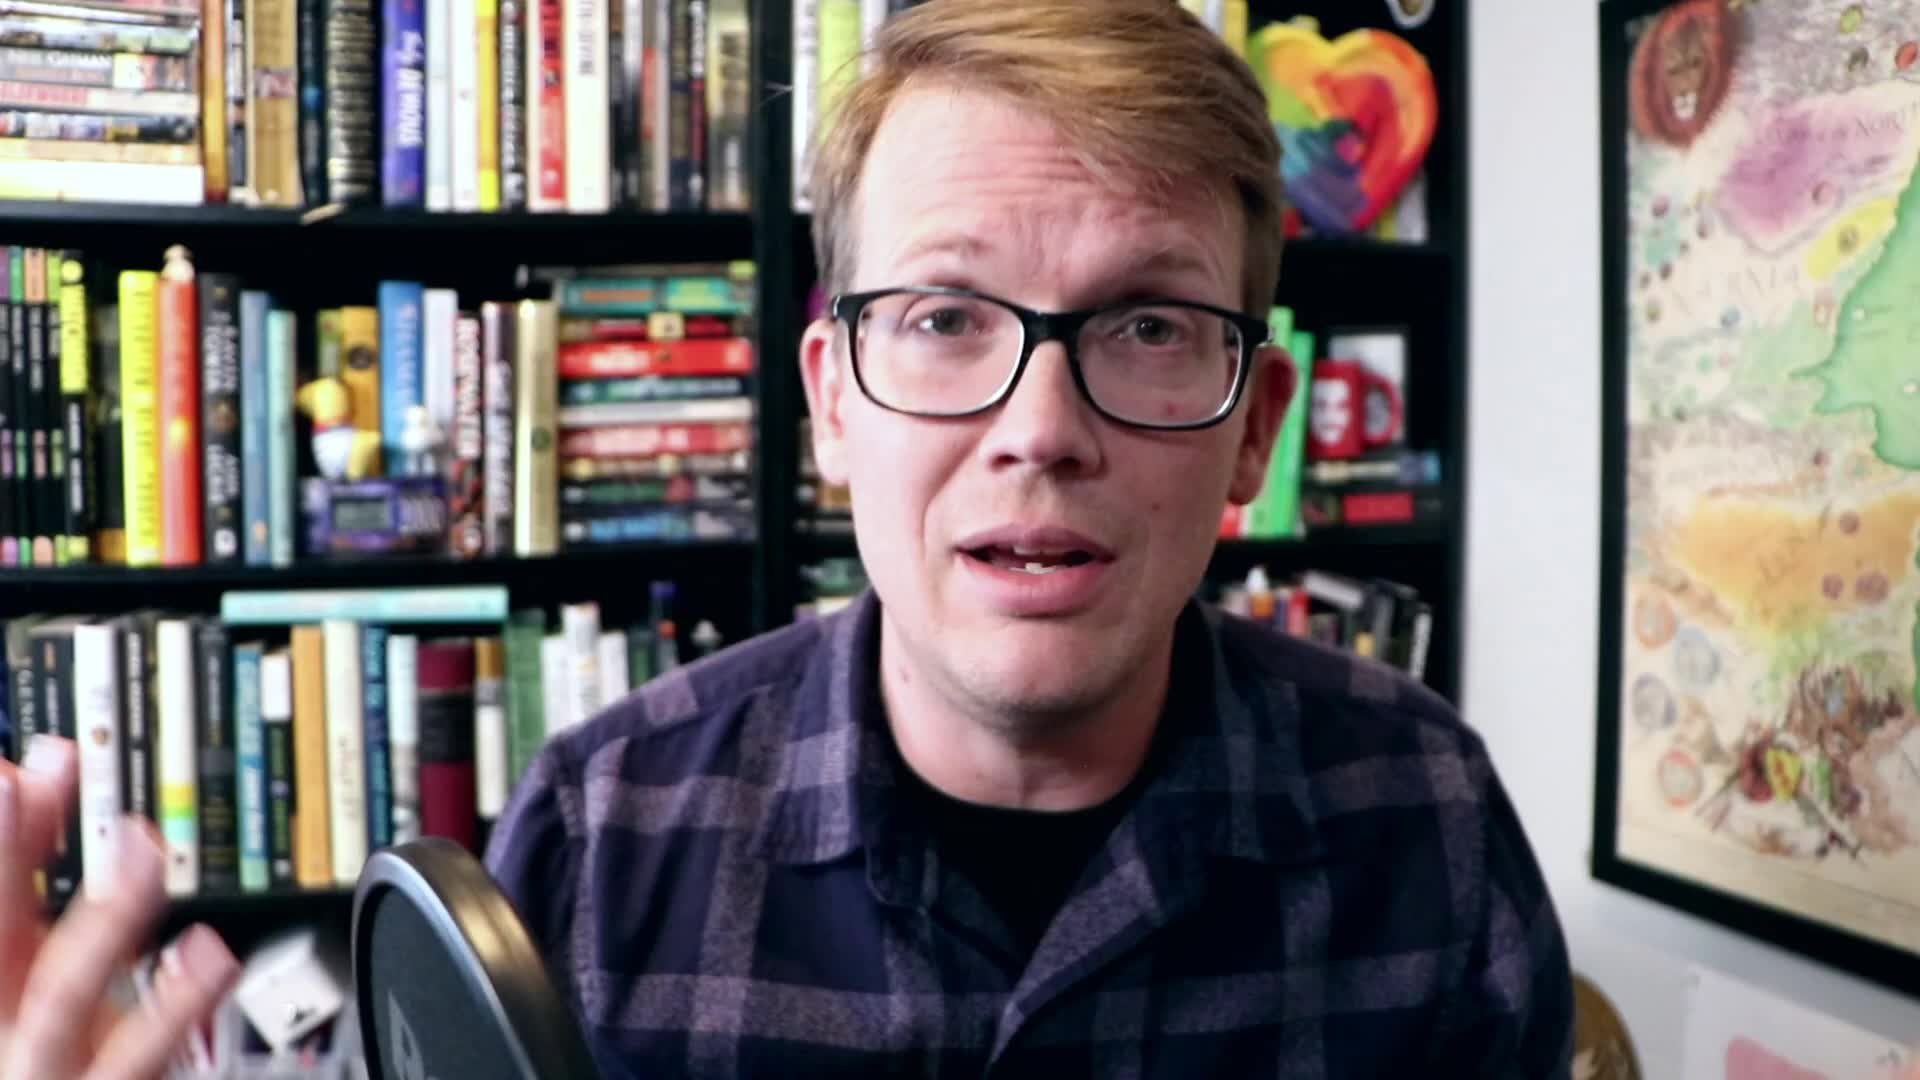

In [5]:
image_path = 'scene-changing frames/frame-01.jpg'
image = Image.open(image_path).convert('RGB')
image

In [4]:
sample_image = vit_extractor(images=image, return_tensors='pt')['pixel_values']
df = pd.read_csv('HCCAW.csv', header=None)
sample_text = df[1][1]

model.eval()
with torch.no_grad():
    logits = model(sample_image, sample_text)
    stance = torch.argmax(logits, dim=1)

stance_labels = ['support', 'oppose', 'neutral']
print(f"Detected Stance: {stance_labels[stance.item()]}")

Detected Stance: neutral
